## Table Transformer: inference notebook

In this notebook, we are going to run the Table Transformer - which is actually a [DETR](https://arxiv.org/abs/2005.12872) model - by Microsoft Research (which is part of 🤗 Transformers) to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works.

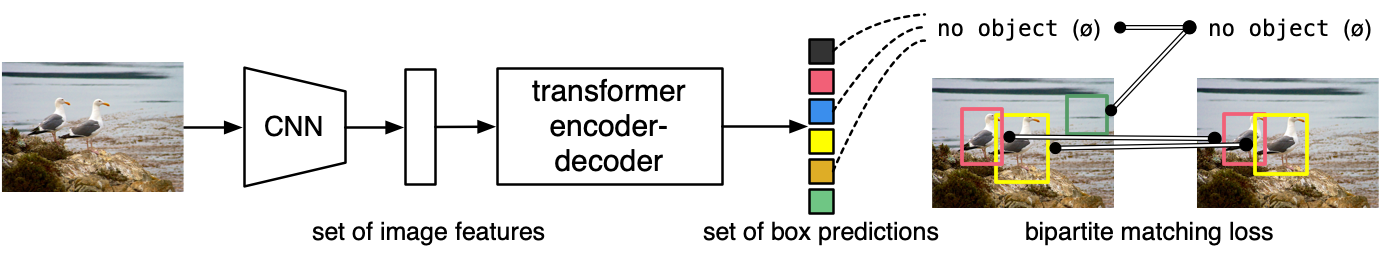

* Table Transformer paper: https://arxiv.org/abs/2110.00061
* DETR Paper: https://arxiv.org/abs/2005.12872
* DETR Blog post: https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
* Official Github repository: https://github.com/facebookresearch/detr

My other DETR notebooks (which showcase how you can fine-tune DETR on a custom dataset, both for object detection and panoptic segmentation) can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR).


## 0. Path

In [ ]:
%pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
%pip install -q timm

## 1. Table detection

In [1]:
import os
from io import StringIO
from pathlib import Path
from pathlib import WindowsPath

### Config

In [3]:
sample_file = r"pdf_tools_samples\do-01780.pdf"

In [3]:
pdf_pages = r"pdf_tools_samples/pdf_tools_pages/page_"

In [2]:
poppler_path = r'C:\Users\danie\Downloads\Release-23.07.0-0\poppler-23.07.0\Library\bin'

In [3]:
file = r".\data\data_teste\documentos_pdf_teste\do-01764.pdf"

In [5]:
file = r".\data\data_teste\documentos_pdf_teste\272519EC-959B-4460-BBE6-D80D272B9ACD.PDF"

In [6]:
# Yes!!!!!
from pdf2image import convert_from_path
pages = convert_from_path(file, 500,poppler_path)

image_counter = 1

for page in pages:
    filename = pdf_pages + str(image_counter) + ".jpg"
    page.save(filename, 'JPEG')
    image_counter = image_counter + 1

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file '.\data\data_teste\documentos_pdf_teste\272519EC-959B-4460-BBE6-D80D272B9ACD.PDF': No error.


In [2]:
from PIL import Image

In [6]:
Image_file = "pdf_tools_samples\pdf_tools_pages\page_21_4.jpg"

In [7]:
# Dados originais
file_path = Image_file
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

NameError: name 'Image' is not defined

In [8]:
file_path = Image_file
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*1), int(height*1)))

NameError: name 'Image' is not defined

In [6]:
from transformers import DetrImageProcessor

feature_extractor = DetrImageProcessor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [7]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 370, 1334])


In [8]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [9]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [10]:
import matplotlib.pyplot as plt

In [11]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [12]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

In [ ]:
results['scores']

In [ ]:
results['labels']

In [ ]:
results['boxes']

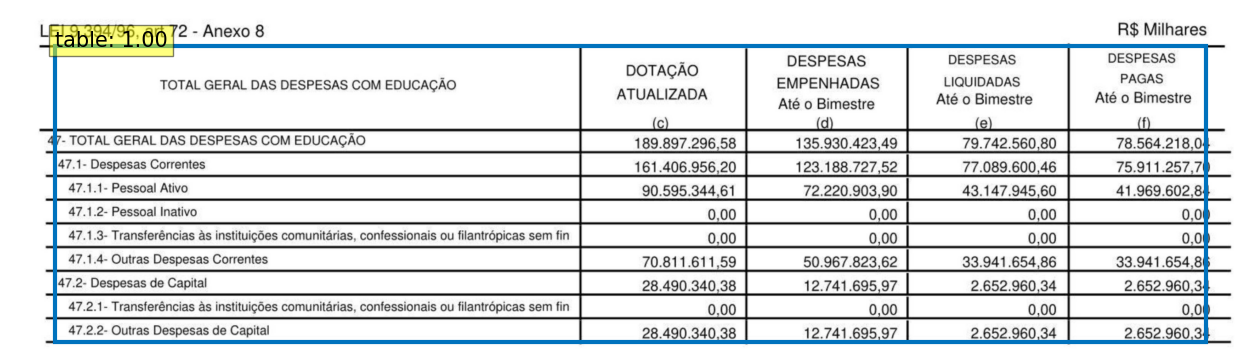

In [13]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

## Table structure recognition



In [ ]:
file_path = "pdf_tools_samples\images\image1_2.png"

In [ ]:
file_path = "pdf_tools_samples\images\image7_2.jpeg"

In [ ]:
file_path = "pdf_tools_samples\images\image21_3.jpg"

In [33]:
file_path = "pdf_tools_samples\images\image21_4.jpg"

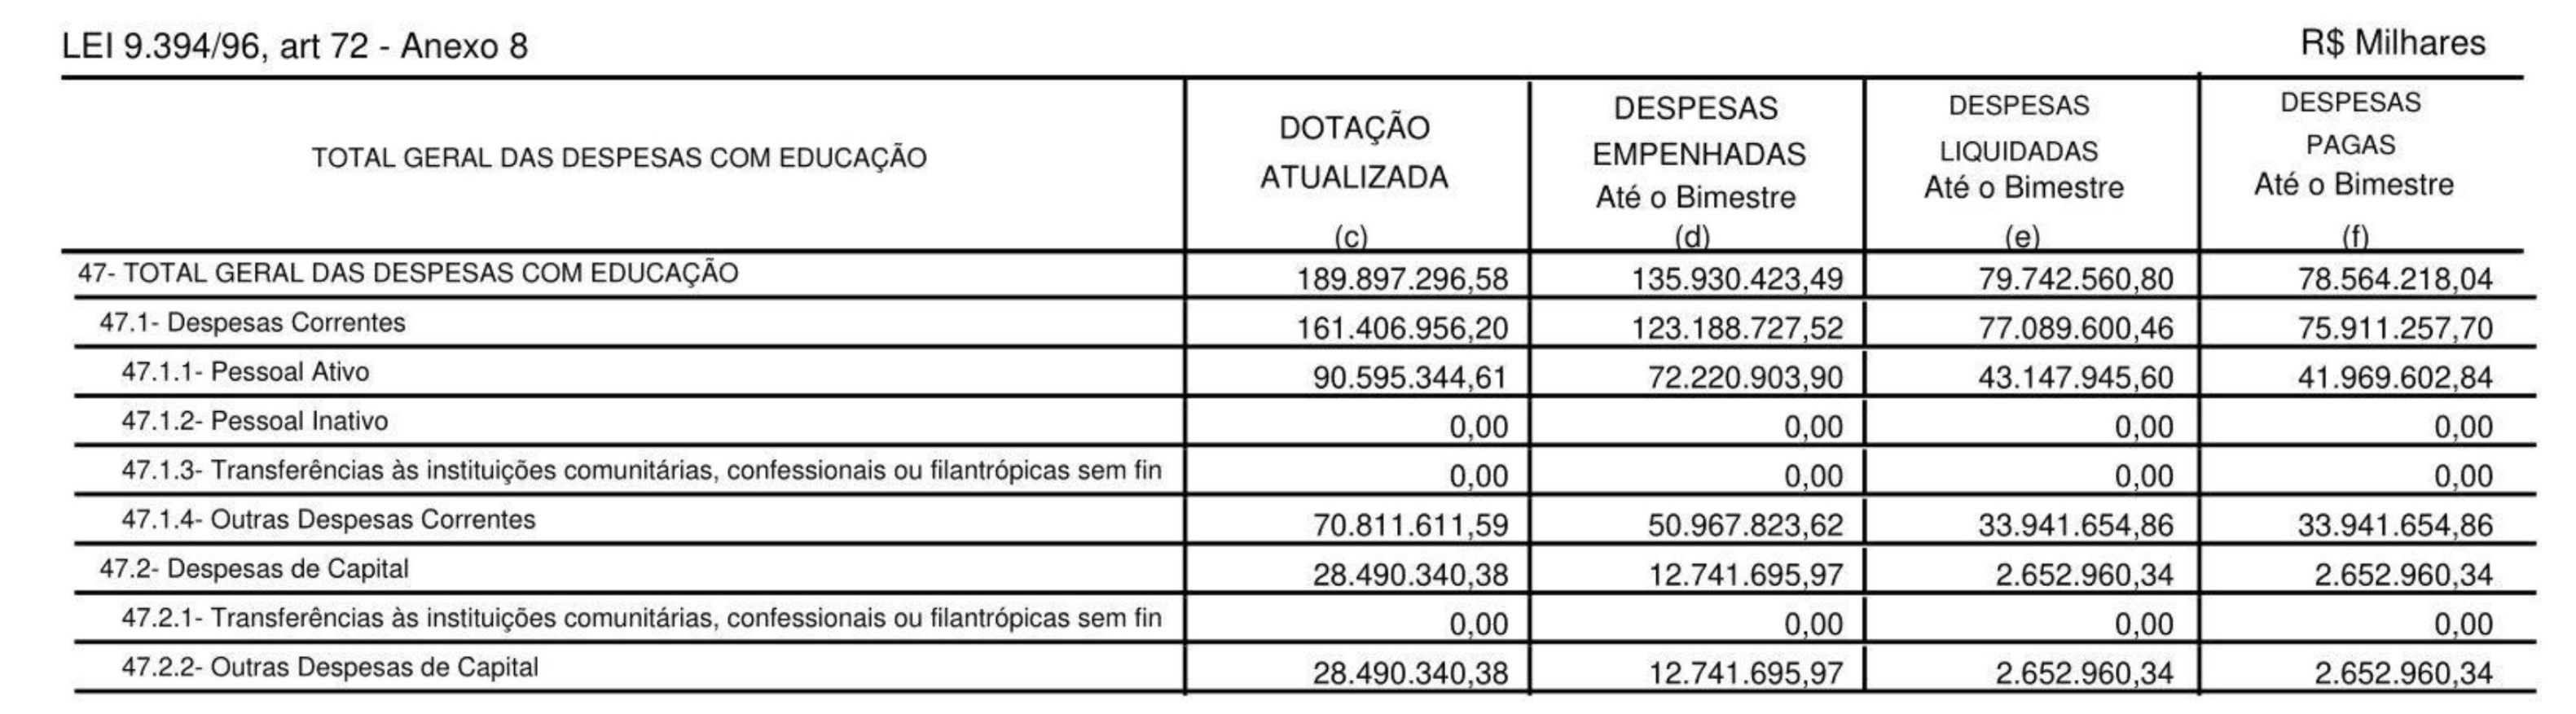

In [15]:
from huggingface_hub import hf_hub_download
from PIL import Image

factor = 1
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*factor), int(height*factor)))

In [16]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

with torch.no_grad():
  outputs = model(**encoding)

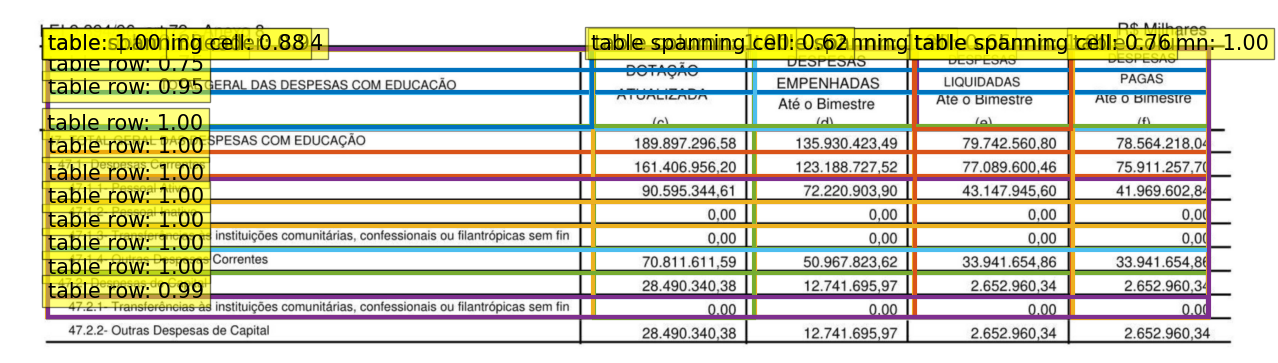

In [17]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [90]:
results['scores']

tensor([0.9991, 0.9955, 0.9998, 0.6609, 0.9995, 0.9514, 0.7503, 0.9975, 1.0000,
        0.9996, 0.9994, 0.6238, 0.8180, 0.9998, 0.9999, 0.9947, 0.9378, 0.9993,
        0.8837, 0.7560, 0.9992, 1.0000])

In [91]:
results['labels']

tensor([2, 2, 1, 5, 1, 2, 2, 2, 1, 2, 2, 5, 2, 1, 1, 2, 3, 2, 5, 5, 2, 0])

In [53]:
results['boxes']

tensor([[  96.4039,  672.4431, 3055.3345,  733.9739],
        [  94.6118,  306.3553, 3056.2683,  365.0970],
        [1900.1951,  102.3132, 2304.5715,  785.8562],
        [1895.4778,  101.9821, 2313.3247,  305.2487],
        [1488.8474,  102.6801, 1896.3533,  786.0309],
        [  96.0786,  212.8632, 3055.1633,  305.4579],
        [  96.4578,  154.6371, 3055.0522,  211.7314],
        [  95.3104,  364.1534, 3055.8630,  424.1874],
        [  94.8717,  102.8822, 1486.6680,  785.3152],
        [  95.6396,  431.9167, 3056.7163,  492.0305],
        [  96.1697,  611.9898, 3056.1907,  673.0897],
        [1481.1074,  100.9834, 1899.1747,  298.9818],
        [  96.3300,  101.9032, 3055.3896,  153.8320],
        [2308.3213,  102.0326, 2706.3591,  785.9554],
        [2709.6521,  102.1562, 3055.0979,  785.9889],
        [  96.5481,  733.6919, 3055.3064,  785.1290],
        [  95.3115,  102.1671, 3056.1692,  298.3501],
        [  95.8826,  552.0701, 3055.9771,  612.6735],
        [  96.8517,  101.919

In [50]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [66]:
import cv2
from PIL import Image
import pytesseract
import torch

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

# Exemplo de coordenadas dos retângulos
# (x_min, y_min, x_max, y_max)
dados_da_tabela = results['boxes']
labels_ids = results['labels']


# Classe para representar uma célula da tabela
class CelulaTabela:
    def __init__(self, coordenadas, label, texto):
        self.coordenadas = coordenadas
        self.label = label
        self.texto = texto

In [67]:
# Função para recortar a imagem com base nas coordenadas do retângulo
def recortar_imagem(img, coordenadas):
    x_min, y_min, x_max, y_max = coordenadas
    return img[int(y_min):int(y_max), int(x_min):int(x_max)]

In [68]:
# Carregue a imagem do PDF (ou outra fonte)
img_pdf = cv2.imread(file_path, cv2.IMREAD_COLOR)


In [70]:
# Processo de OCR para cada célula e preenchimento do dicionário
for i in range(dados_da_tabela['pixel_values'].shape[0]):
    retangulo = dados_da_tabela['pixel_values'][i].tolist()
    img_celula = recortar_imagem(img_pdf, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, config=tesseract_config, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = dados_da_tabela['labels'][i].item() if isinstance(dados_da_tabela['labels'][i], torch.Tensor) else dados_da_tabela['labels'][i]
    label_descritivo = model.config.id2label[label_id]
    
    # Adicionar as informações ao dicionário
    chave_celula = f'celula_{i}'
    dados_da_tabela[chave_celula] = {
        'coordenadas': retangulo,
        'label': label_descritivo,
        'texto': texto_celula
    }

# Remover as chaves originais, pois foram substituídas pelas chaves com informações completas
chaves_originais = ['pixel_values', 'labels']
for chave_original in chaves_originais:
    dados_da_tabela.pop(chave_original)

# Agora o dicionário 'dados_da_tabela' contém informações completas de cada célula detectada
print(dados_da_tabela)


IndexError: too many indices for tensor of dimension 2

In [76]:
print(dados_da_tabela['labels'].shape)





IndexError: too many indices for tensor of dimension 2

In [77]:
print(dados_da_tabela['boxes'].shape)

IndexError: too many indices for tensor of dimension 2

In [78]:
print(dados_da_tabela['labels'])

IndexError: too many indices for tensor of dimension 2

In [79]:
print(dados_da_tabela['labels'])


IndexError: too many indices for tensor of dimension 2

In [80]:
print(dados_da_tabela['labels'][0])


IndexError: too many indices for tensor of dimension 2

In [81]:
dados_da_tabela.shape

torch.Size([22, 4])

In [86]:
print(dados_da_tabela['labels'].shape)

IndexError: too many indices for tensor of dimension 2

In [83]:
print(dados_da_tabela['pixel_values'][:, :])


IndexError: too many indices for tensor of dimension 2

In [57]:
# Função para recortar a imagem
def recortar_imagem(img, coordenadas):
    x_min, y_min, x_max, y_max = coordenadas
    return img[y_min:y_max, x_min:x_max]

# Exemplo de uso da função
import numpy as np

# Criar uma imagem de exemplo
img_exemplo = np.zeros((800, 1000), dtype=np.uint8)  # Imagem preta de 1000x800 pixels

# Definir coordenadas para recortar uma região retangular na imagem
coordenadas_exemplo = [100, 200, 400, 500]

# Recortar a região da imagem
regiao_recortada = recortar_imagem(img_exemplo, coordenadas_exemplo)

# Imprimir a forma da região recortada
print(regiao_recortada.shape)


(300, 300)


In [69]:
# Processo de OCR para cada célula e preenchimento do dicionário
for i in range(dados_da_tabela['labels'].shape[0]):
    retangulo = dados_da_tabela['pixel_values'][i].tolist()
    img_celula = recortar_imagem(img_pdf, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, config=tesseract_config, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = dados_da_tabela['labels'][i].item() if isinstance(dados_da_tabela['labels'][i], torch.Tensor) else dados_da_tabela['labels'][i]
    label_descritivo = model.config.id2label[label_id]
    
    # Adicionar as informações ao dicionário
    chave_celula = f'celula_{i}'
    dados_da_tabela[chave_celula] = {
        'coordenadas': retangulo,
        'label': label_descritivo,
        'texto': texto_celula
    }

# Remover as chaves originais, pois foram substituídas pelas chaves com informações completas
chaves_originais = ['pixel_values', 'labels']
for chave_original in chaves_originais:
    dados_da_tabela.pop(chave_original)

# Agora o dicionário 'dados_da_tabela' contém informações completas de cada célula detectada
print(dados_da_tabela)


IndexError: too many indices for tensor of dimension 2

In [87]:
print(dados_da_tabela)



tensor([[  96.4039,  672.4431, 3055.3345,  733.9739],
        [  94.6118,  306.3553, 3056.2683,  365.0970],
        [1900.1951,  102.3132, 2304.5715,  785.8562],
        [1895.4778,  101.9821, 2313.3247,  305.2487],
        [1488.8474,  102.6801, 1896.3533,  786.0309],
        [  96.0786,  212.8632, 3055.1633,  305.4579],
        [  96.4578,  154.6371, 3055.0522,  211.7314],
        [  95.3104,  364.1534, 3055.8630,  424.1874],
        [  94.8717,  102.8822, 1486.6680,  785.3152],
        [  95.6396,  431.9167, 3056.7163,  492.0305],
        [  96.1697,  611.9898, 3056.1907,  673.0897],
        [1481.1074,  100.9834, 1899.1747,  298.9818],
        [  96.3300,  101.9032, 3055.3896,  153.8320],
        [2308.3213,  102.0326, 2706.3591,  785.9554],
        [2709.6521,  102.1562, 3055.0979,  785.9889],
        [  96.5481,  733.6919, 3055.3064,  785.1290],
        [  95.3115,  102.1671, 3056.1692,  298.3501],
        [  95.8826,  552.0701, 3055.9771,  612.6735],
        [  96.8517,  101.919

In [88]:
dados_da_tabela.shape

torch.Size([22, 4])

In [55]:
labels_ids.shape

torch.Size([22])

In [56]:
# Processo de OCR para cada célula e preenchimento do dicionário
for i in range(dados_da_tabela.shape[0]):
    retangulo = dados_da_tabela[i, :].tolist()  # Converter o tensor para uma lista de coordenadas
    img_celula = recortar_imagem(file_path, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, config=tesseract_config, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = dados_da_tabela['labels'][i].item() if isinstance(dados_da_tabela['labels'][i], torch.Tensor) else dados_da_tabela['labels'][i]
    label_descritivo = model.config.id2label[label_id]
    
    # Adicionar as informações ao dicionário
    chave_celula = f'celula_{i}'
    dados_da_tabela[chave_celula] = {
        'coordenadas': retangulo,
        'label': label_descritivo,
        'texto': texto_celula
    }

# Remover as chaves originais, pois foram substituídas pelas chaves com informações completas
chaves_originais = ['pixel_values', 'labels']
for chave_original in chaves_originais:
    dados_da_tabela.pop(chave_original)

# Agora o dicionário 'dados_da_tabela' contém informações completas de cada célula detectada
print(dados_da_tabela)


TypeError: string indices must be integers

In [89]:
dados_da_tabela['labels']

IndexError: too many indices for tensor of dimension 2

In [47]:
# Processo de OCR para cada célula e preenchimento do dicionário
for i in range(dados_da_tabela.shape[0]):
    retangulo = dados_da_tabela[i, :]
    img_celula = recortar_imagem(file_path, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, config=tesseract_config, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = dados_da_tabela['labels'][i].item() if isinstance(dados_da_tabela['labels'][i], torch.Tensor) else dados_da_tabela['labels'][i]
    label_descritivo = model.config.id2label[label_id]
    
    # Adicionar as informações ao dicionário
    chave_celula = f'celula_{i}'
    dados_da_tabela[chave_celula] = {
        'coordenadas': retangulo.tolist(),
        'label': label_descritivo,
        'texto': texto_celula
    }

# Remover as chaves originais, pois foram substituídas pelas chaves com informações completas
chaves_originais = ['pixel_values', 'labels']
for chave_original in chaves_originais:
    dados_da_tabela.pop(chave_original)

# Agora o dicionário 'dados_da_tabela' contém informações completas de cada célula detectada
print(dados_da_tabela)


TypeError: string indices must be integers

In [37]:
# Processo de OCR para cada célula e preenchimento do dicionário
#tesseract_config = '--oem 1'  # Defina as configurações específicas do Tesseract aqui, se necessário
for i in range(len(dados_da_tabela['pixel_values'])):
    retangulo = dados_da_tabela['pixel_values'][i]
    img_celula = recortar_imagem(file_path, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, config=tesseract_config, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = dados_da_tabela['labels'][i].item() if isinstance(dados_da_tabela['labels'][i], torch.Tensor) else dados_da_tabela['labels'][i]
    label_descritivo = model.config.id2label[label_id]
    
    # Adicionar as informações ao dicionário
    chave_celula = f'celula_{i}'
    dados_da_tabela[chave_celula] = {
        'coordenadas': retangulo.tolist(),
        'label': label_descritivo,
        'texto': texto_celula
    }

# Remover as chaves originais, pois foram substituídas pelas chaves com informações completas
chaves_originais = ['pixel_values', 'pixel_mask', 'labels']
for chave_original in chaves_originais:
    dados_da_tabela.pop(chave_original)

# Agora o dicionário 'dados_da_tabela' contém informações completas de cada célula detectada
print(dados_da_tabela)


IndexError: too many indices for tensor of dimension 2

In [41]:
# Verificar o tipo de dados do tensor 'pixel_values'
print(type(dados_da_tabela['pixel_values']))

# Verificar a forma do tensor 'pixel_values'
print(dados_da_tabela['pixel_values'].shape)

# Verificar o tipo de dados do tensor 'labels'
print(type(dados_da_tabela['labels']))

# Verificar a forma do tensor 'labels'
print(dados_da_tabela['labels'].shape)




IndexError: too many indices for tensor of dimension 2

In [42]:
# Verificar os elementos do tensor 'pixel_values'
print(dados_da_tabela['pixel_values'])

# Verificar os elementos do tensor 'labels'
print(dados_da_tabela['labels'])


IndexError: too many indices for tensor of dimension 2

In [43]:
# Remover as chaves originais, pois foram substituídas pelas chaves com informações completas
chaves_originais = list(range(len(dados_da_tabela)))
for chave_original in chaves_originais:
    dados_da_tabela.pop(chave_original)

AttributeError: 'Tensor' object has no attribute 'pop'

In [30]:
celulas_detectadas = []
for i in range(len(dados_da_tabela)):
    retangulo = dados_da_tabela[i]
    img_celula = recortar_imagem(file_path, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = labels_ids[i].item() if isinstance(labels_ids[i], torch.Tensor) else labels_ids[i]
    label_descritivo = model.config.id2label[label_id]
    
    # Criar objeto CelulaTabela e adicioná-lo à lista de células_detectadas
    celula = CelulaTabela(coordenadas=retangulo, label=label_descritivo, texto=texto_celula)
    celulas_detectadas.append(celula)

# Agora a lista celulas_detectadas contém objetos CelulaTabela com informações de cada célula detectada
# Você pode acessar as informações de cada célula usando os atributos da classe
for celula in celulas_detectadas:
    print("Coordenadas:", celula.coordenadas)
    print("Label:", celula.label)
    print("Texto:", celula.texto)
    print("-" * 30)

TypeError: string indices must be integers

In [ ]:
# Função para recortar a imagem com base nas coordenadas do retângulo
def recortar_imagem(img, coordenadas):
    x_min, y_min, x_max, y_max = coordenadas
    return img[int(y_min):int(y_max), int(x_min):int(x_max)]

# Processo de OCR para cada célula e preenchimento do dicionário
for i, retangulo in enumerate(retangulos):
    img_celula = recortar_imagem(img_pdf, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, lang='por')
    
    # Mapear o ID numérico do rótulo para o rótulo descritivo usando model.config.id2label
    label_id = labels_ids[i]
    label_descritivo = model.config.id2label[label_id]
    
    # Adicionar as informações ao dicionário
    chave_celula = f'celula_{i}'
    dados_da_tabela[chave_celula] = {
        'coordenadas': retangulo,
        'label': label_descritivo,
        'texto': texto_celula
    }

# Agora o dicionário 'dados_da_tabela' contém informações completas de cada célula detectada
print(dados_da_tabela)


In [ ]:

dados_da_tabela = {}
for i, retangulo in enumerate(retangulos):
    img_celula = recortar_imagem(img_pdf, retangulo)
    texto_celula = pytesseract.image_to_string(img_celula, lang='por')
    chave_celula = f'celula_{i}'  # Ou use outra forma de identificar a célula, se preferir
    dados_da_tabela[chave_celula] = texto_celula

# Agora 'dados_da_tabela' é um dicionário que mapeia cada célula ao seu conteúdo lido pelo OCR.
print(dados_da_tabela)

In [ ]:
retangulos

In [ ]:
labels_ids

In [ ]:
for dado in dados_da_tabela.items():
    print(dado)

In [ ]:

# Exemplo de resultados de OCR para cada célula
texto_das_celulas = ["Conteúdo da célula 1", "Conteúdo da célula 2", "..."]

# Criação do dicionário para armazenar os dados de cada detecção
dados_da_tabela = []

for i, label_id in enumerate(labels_ids):
    # Obtém o rótulo descritivo com base no ID numérico usando model.config.id2label
    rótulo_descritivo = model.config.id2label[label_id]

    # Obtém o texto correspondente à célula detectada usando o OCR
    texto_celula = texto_das_celulas[i]

    # Armazena todas as informações relevantes sobre a detecção em um dicionário
    detecao = {
        'label': rótulo_descritivo,
        'texto': texto_celula,
        # Adicione aqui outras informações relevantes, como coordenadas do retângulo, confiança da detecção, etc.
    }

    # Adiciona o dicionário da detecção à lista geral de dados da tabela
    dados_da_tabela.append(detecao)

# Agora 'dados_da_tabela' é uma lista de dicionários, cada dicionário contendo informações sobre uma detecção.
print(dados_da_tabela)


### Using Thinker